In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim


Train Shape: (41348, 7)
Test  Shape: (7297, 7)

Data Types:
neighbourhood_group     object
room_type               object
minimum_nights         float64
amenity_score          float64
number_of_reviews      float64
availability_365       float64
price_class              int64
dtype: object

Missing values per column (train):
neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64


/tmp/ipykernel_32741/1432696265.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='price_class', data=train_df, palette='viridis')
/tmp/ipykernel_32741/1432696265.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([labels[int(t.get_text())] for t in ax.get_xticklabels()])


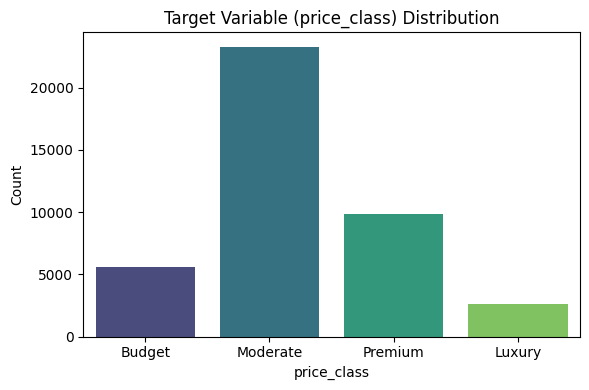

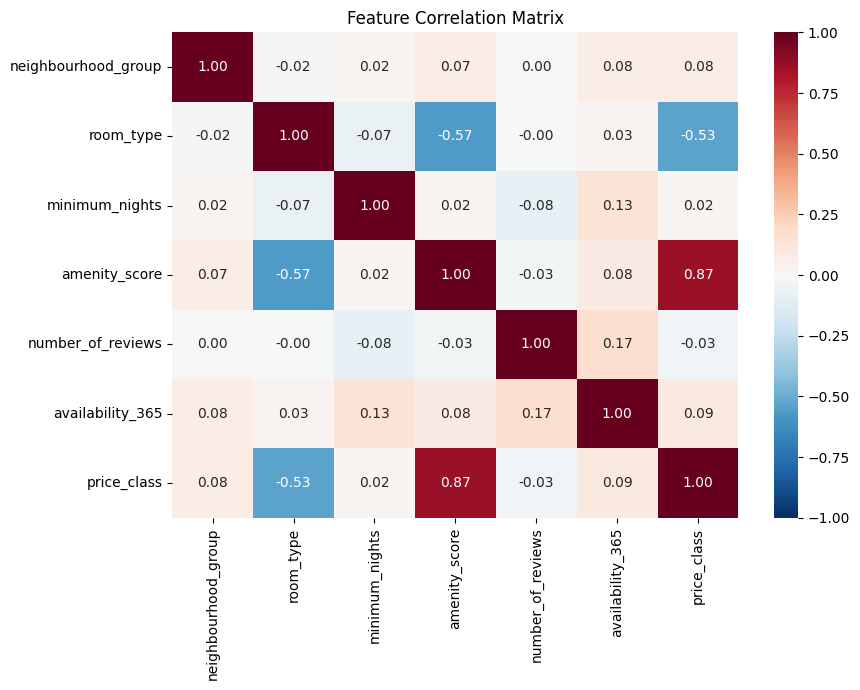


Train: (33078, 6), Val: (8270, 6)


In [10]:
# PART A: 

train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')


print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")
print(f"\nData Types:\n{train_df.dtypes}")


print("\nMissing values per column (train):")
print(train_df.isnull().sum())
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        fill_val = train_df[col].mode()[0]
        train_df[col].fillna(fill_val, inplace=True)
        test_df[col].fillna(fill_val, inplace=True)   
    else:
        fill_val = train_df[col].median()
        train_df[col].fillna(fill_val, inplace=True)
        test_df[col].fillna(fill_val, inplace=True)    


plt.figure(figsize=(6, 4))
labels = {0: 'Budget', 1: 'Moderate', 2: 'Premium', 3: 'Luxury'}
ax = sns.countplot(x='price_class', data=train_df, palette='viridis')
ax.set_xticklabels([labels[int(t.get_text())] for t in ax.get_xticklabels()])
plt.title("Target Variable (price_class) Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

cat_cols = ['neighbourhood_group', 'room_type']
for col in cat_cols:
    combined_cats = pd.Categorical(train_df[col]).categories
    train_df[col] = pd.Categorical(train_df[col], categories=combined_cats).codes
    test_df[col]  = pd.Categorical(test_df[col],  categories=combined_cats).codes



plt.figure(figsize=(9, 7))
corr = train_df.corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt='.2f', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


feature_cols = [c for c in train_df.columns if c != 'price_class']
X       = train_df[feature_cols].values
y       = train_df['price_class'].values
X_test_final  = test_df[feature_cols].values
y_test_final  = test_df['price_class'].values

scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)


X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}")


In [11]:
# PART B(a): 

class NumpyMLP:
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        self.activation_type = activation
        self.output_size = output_size

        # scale1 = np.sqrt(2.0 / input_size)  if activation == 'relu' else np.sqrt(1.0 / input_size)
        # scale2 = np.sqrt(2.0 / hidden_size) if activation == 'relu' else np.sqrt(1.0 / hidden_size)

        self.W1 = np.random.randn(input_size,  hidden_size) / np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) / np.sqrt(input_size)
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, output_size) / np.sqrt(input_size)
        self.b3 = np.zeros((1, output_size))

        self.grad_mags = {'W1': [], 'W2': []}

    def activate(self, z):
        if self.activation_type == 'relu':
            return np.maximum(0, z)
        return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500))) 

    def activate_der(self, a, z=None):

        if self.activation_type == 'relu':
            return (a > 0).astype(float)
        return a * (1.0 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        z1 = X @ self.W1 + self.b1;  a1 = self.activate(z1)
        z2 = a1 @ self.W2 + self.b2; a2 = self.activate(z2)
        z3 = a2 @ self.W3 + self.b3; probs = self.softmax(z3)
        return probs, a1, a2

    def compute_loss(self, probs, y_int):
        
        m = y_int.shape[0]
        log_probs = np.log(probs[np.arange(m), y_int.astype(int)] + 1e-8)
        return -np.mean(log_probs)

    def accuracy(self, probs, y_int):
        return np.mean(np.argmax(probs, axis=1) == y_int)

    def train(self, X, y, X_val, y_val, n_epochs=200, lr=0.01):
        train_accs, val_accs = [], []

        for epoch in range(n_epochs):
            probs, a1, a2 = self.forward(X)
            m = X.shape[0]

            one_hot = np.zeros_like(probs)
            one_hot[np.arange(m), y.astype(int)] = 1.0

            dz3 = (probs - one_hot) / m          
            dW3 = a2.T @ dz3                     
            db3 = dz3.sum(axis=0, keepdims=True) 

            
            dA2 = dz3 @ self.W3.T                
            dz2 = dA2 * self.activate_der(a2)    
            dW2 = a1.T @ dz2                     
            db2 = dz2.sum(axis=0, keepdims=True) 

            
            dA1 = dz2 @ self.W2.T                
            dz1 = dA1 * self.activate_der(a1)    
            dW1 = X.T @ dz1                      
            db1 = dz1.sum(axis=0, keepdims=True) 

            self.grad_mags['W1'].append(np.mean(np.abs(dW1)))
            self.grad_mags['W2'].append(np.mean(np.abs(dW2)))

            self.W1 -= lr * dW1 
            self.b1 -= lr * db1
            self.W2 -= lr * dW2 
            self.b2 -= lr * db2
            self.W3 -= lr * dW3
            self.b3 -= lr * db3

            
            train_acc = self.accuracy(probs, y)
            val_probs, _, _ = self.forward(X_val)
            val_acc = self.accuracy(val_probs, y_val)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            loss = self.compute_loss(probs, y)
            print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        return train_accs, val_accs


In [15]:
np.random.seed(42)
relu_mlp = NumpyMLP(X_train.shape[1], hidden_size=32, output_size=4, activation='relu')
r_train_accs, r_val_accs = relu_mlp.train(X_train, y_train, X_val, y_val, n_epochs=300, lr=0.1)


Epoch   1 | Loss: 2.4612 | Train Acc: 0.1691 | Val Acc: 0.3631
Epoch   2 | Loss: 1.6976 | Train Acc: 0.3647 | Val Acc: 0.4836
Epoch   3 | Loss: 1.3794 | Train Acc: 0.4815 | Val Acc: 0.5291
Epoch   4 | Loss: 1.1985 | Train Acc: 0.5266 | Val Acc: 0.5614
Epoch   5 | Loss: 1.0808 | Train Acc: 0.5613 | Val Acc: 0.6034
Epoch   6 | Loss: 0.9979 | Train Acc: 0.6008 | Val Acc: 0.6359
Epoch   7 | Loss: 0.9365 | Train Acc: 0.6351 | Val Acc: 0.6585
Epoch   8 | Loss: 0.8891 | Train Acc: 0.6605 | Val Acc: 0.6721
Epoch   9 | Loss: 0.8509 | Train Acc: 0.6739 | Val Acc: 0.6845
Epoch  10 | Loss: 0.8193 | Train Acc: 0.6824 | Val Acc: 0.6907
Epoch  11 | Loss: 0.7928 | Train Acc: 0.6906 | Val Acc: 0.6952
Epoch  12 | Loss: 0.7701 | Train Acc: 0.6965 | Val Acc: 0.6977
Epoch  13 | Loss: 0.7504 | Train Acc: 0.7023 | Val Acc: 0.7019
Epoch  14 | Loss: 0.7328 | Train Acc: 0.7066 | Val Acc: 0.7051
Epoch  15 | Loss: 0.7169 | Train Acc: 0.7125 | Val Acc: 0.7099
Epoch  16 | Loss: 0.7024 | Train Acc: 0.7174 | Val Acc:

In [16]:

# Train Sigmoid model
np.random.seed(42)
sig_mlp = NumpyMLP(X_train.shape[1], hidden_size=32, output_size=4, activation='sigmoid')
s_train_accs, s_val_accs = sig_mlp.train(X_train, y_train, X_val, y_val, n_epochs=300, lr=0.1)


Epoch   1 | Loss: 1.5895 | Train Acc: 0.1109 | Val Acc: 0.5063
Epoch   2 | Loss: 1.3024 | Train Acc: 0.5034 | Val Acc: 0.5613
Epoch   3 | Loss: 1.2087 | Train Acc: 0.5611 | Val Acc: 0.5623
Epoch   4 | Loss: 1.1740 | Train Acc: 0.5621 | Val Acc: 0.5630
Epoch   5 | Loss: 1.1559 | Train Acc: 0.5627 | Val Acc: 0.5632
Epoch   6 | Loss: 1.1438 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch   7 | Loss: 1.1347 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch   8 | Loss: 1.1275 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch   9 | Loss: 1.1216 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  10 | Loss: 1.1167 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  11 | Loss: 1.1124 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  12 | Loss: 1.1087 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  13 | Loss: 1.1054 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  14 | Loss: 1.1023 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  15 | Loss: 1.0995 | Train Acc: 0.5632 | Val Acc: 0.5632
Epoch  16 | Loss: 1.0968 | Train Acc: 0.5632 | Val Acc:

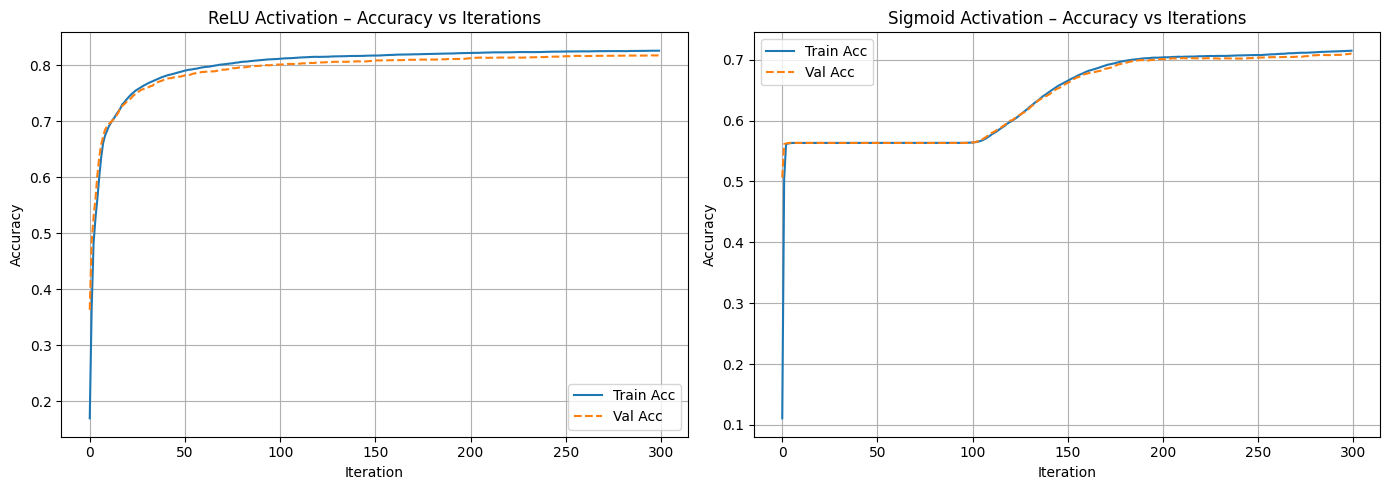


ReLU   | Final Train Acc: 0.8260 | Val Acc: 0.8177
Sigmoid | Final Train Acc: 0.7146 | Val Acc: 0.7100


In [17]:

# Part B(a):
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (ta, va, label) in zip(axes, [
        (r_train_accs, r_val_accs, 'ReLU'),
        (s_train_accs, s_val_accs, 'Sigmoid')]):
    ax.plot(ta, label='Train Acc')
    ax.plot(va, label='Val Acc',  linestyle='--')
    ax.set_title(f'{label} Activation – Accuracy vs Iterations')
    ax.set_xlabel('Iteration'); ax.set_ylabel('Accuracy')
    ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()

print(f"\nReLU   | Final Train Acc: {r_train_accs[-1]:.4f} | Val Acc: {r_val_accs[-1]:.4f}")
print(f"Sigmoid | Final Train Acc: {s_train_accs[-1]:.4f} | Val Acc: {s_val_accs[-1]:.4f}")


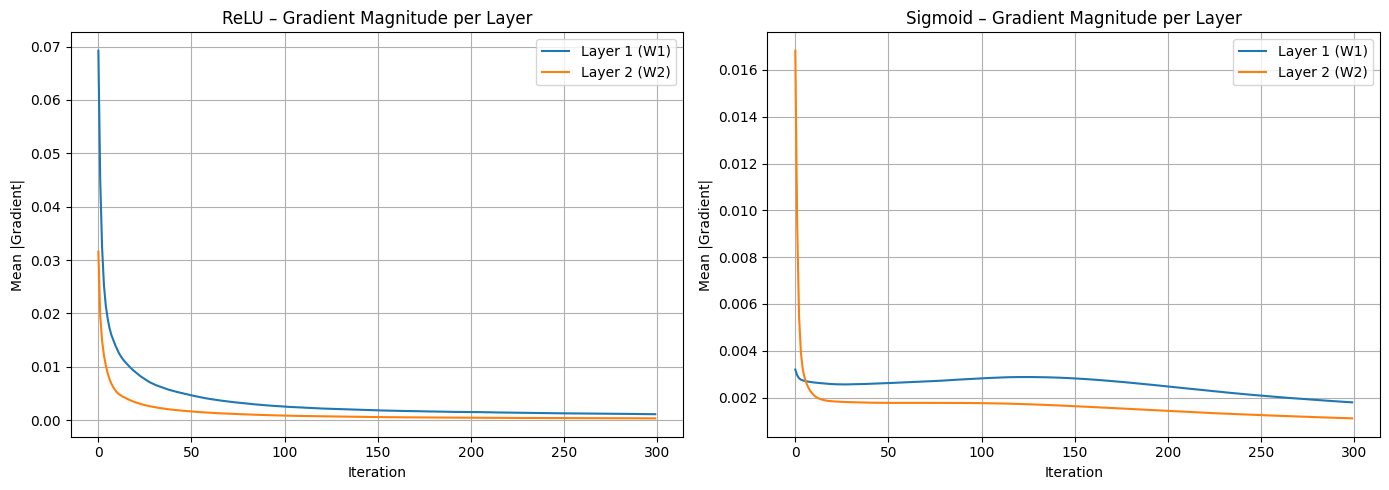

Final Epoch Gradient Magnitude

ReLU:
  W1 (layer 1): 0.001115
  W2 (layer 2): 0.000336
  Ratio W1/W2:  3.3149 

Sigmoid:
  W1 (layer 1): 0.001795
  W2 (layer 2): 0.001112
  Ratio W1/W2:  1.6139 


In [19]:
# PART B(b): 

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, mlp, label in zip(axes, [relu_mlp, sig_mlp], ['ReLU', 'Sigmoid']):
    ax.plot(mlp.grad_mags['W1'], label='Layer 1 (W1)')
    ax.plot(mlp.grad_mags['W2'], label='Layer 2 (W2)')
    ax.set_title(f'{label} – Gradient Magnitude per Layer')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Mean |Gradient|')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

print("Final Epoch Gradient Magnitude")
for mlp, label in [(relu_mlp, 'ReLU'), (sig_mlp, 'Sigmoid')]:
    print(f"\n{label}:")
    print(f"  W1 (layer 1): {mlp.grad_mags['W1'][-1]:.6f}")
    print(f"  W2 (layer 2): {mlp.grad_mags['W2'][-1]:.6f}")
    ratio = mlp.grad_mags['W1'][-1] / (mlp.grad_mags['W2'][-1] + 1e-10)
    print(f"  Ratio W1/W2:  {ratio:.4f} ")


Epoch 1/300 | Loss: 1.3602 | Train Accuracy: 0.4413
Epoch 2/300 | Loss: 1.3318 | Train Accuracy: 0.5572
Epoch 3/300 | Loss: 1.3058 | Train Accuracy: 0.5636
Epoch 4/300 | Loss: 1.2818 | Train Accuracy: 0.5632
Epoch 5/300 | Loss: 1.2597 | Train Accuracy: 0.5632
Epoch 6/300 | Loss: 1.2391 | Train Accuracy: 0.5632
Epoch 7/300 | Loss: 1.2200 | Train Accuracy: 0.5632
Epoch 8/300 | Loss: 1.2023 | Train Accuracy: 0.5632
Epoch 9/300 | Loss: 1.1859 | Train Accuracy: 0.5632
Epoch 10/300 | Loss: 1.1708 | Train Accuracy: 0.5632
Epoch 11/300 | Loss: 1.1568 | Train Accuracy: 0.5632
Epoch 12/300 | Loss: 1.1440 | Train Accuracy: 0.5632
Epoch 13/300 | Loss: 1.1322 | Train Accuracy: 0.5632
Epoch 14/300 | Loss: 1.1214 | Train Accuracy: 0.5632
Epoch 15/300 | Loss: 1.1116 | Train Accuracy: 0.5632
Epoch 16/300 | Loss: 1.1026 | Train Accuracy: 0.5632
Epoch 17/300 | Loss: 1.0942 | Train Accuracy: 0.5632
Epoch 18/300 | Loss: 1.0866 | Train Accuracy: 0.5632
Epoch 19/300 | Loss: 1.0795 | Train Accuracy: 0.5632
Ep

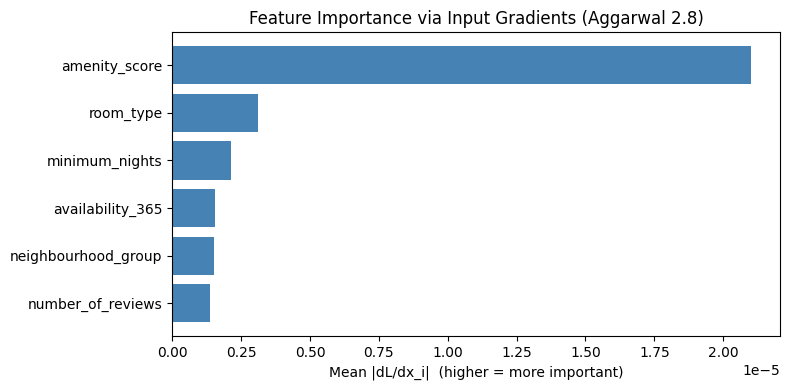

In [23]:
# PART C(b):

torch.manual_seed(42)


input_size  = X_train.shape[1]   
hidden_size = 32
output_size = 4                   

layer1 = nn.Linear(input_size,  hidden_size)   
relu1  = nn.ReLU()

layer2 = nn.Linear(hidden_size, hidden_size)   
relu2  = nn.ReLU()

layer3 = nn.Linear(hidden_size, output_size)   

model = nn.Sequential(layer1, relu1, layer2, relu2, layer3)


criterion = nn.CrossEntropyLoss()                 
optimizer = optim.SGD(model.parameters(), lr=0.1)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

for epoch in range(300):
    
    predictions = model(X_train_tensor)


    loss = criterion(predictions, y_train_tensor)

    
    optimizer.zero_grad()   
    loss.backward()         

    optimizer.step()

    
    predicted_classes = predictions.argmax(dim=1)
    train_acc = (predicted_classes == y_train_tensor).float().mean().item()
    print(f"Epoch {epoch+1}/300 | Loss: {loss.item():.4f} | Train Accuracy: {train_acc:.4f}")


X_for_sensitivity = torch.tensor(X_scaled, dtype=torch.float32, requires_grad=True)
y_for_sensitivity = torch.tensor(y, dtype=torch.long)


model.eval()


output = model(X_for_sensitivity)
loss_for_grad = criterion(output, y_for_sensitivity)
loss_for_grad.backward()


feature_gradients = X_for_sensitivity.grad          
importance_scores  = feature_gradients.abs().mean(dim=0)  

importance_scores = importance_scores.detach().numpy()

feature_names = [c for c in train_df.columns if c != 'price_class']

feature_importance = list(zip(feature_names, importance_scores))

feature_importance.sort(key=lambda x: x[1], reverse=True)

# for rank, (feat, score) in enumerate(feature_importance, 1):
#     bar = "=" * int(score / max(importance_scores) * 30)
#     print(f"  {rank}. {feat:30s}  {score:.5f}  [{bar}]")

feat_names_sorted = [f for f, _ in feature_importance]
feat_scores_sorted = [s for _, s in feature_importance]

plt.figure(figsize=(8, 4))
plt.barh(feat_names_sorted[::-1], feat_scores_sorted[::-1], color='steelblue')
plt.xlabel('Mean |dL/dx_i|  (higher = more important)')
plt.title('Feature Importance via Input Gradients (Aggarwal 2.8)')
plt.tight_layout()
plt.show()


  PyTorch MLP   | Train: 0.8094 | Test: 0.3743
  NumPy ReLU    | Train: 0.8260 | Val: 0.8177 | Test: 0.3666
  NumPy Sigmoid | Train: 0.7146 | Val: 0.7100 | Test: 0.4821

=== Classification Report (PyTorch, Test Set) ===
              precision    recall  f1-score   support

      Budget       0.18      0.23      0.20       983
    Moderate       0.56      0.45      0.50      4109
     Premium       0.25      0.38      0.30      1737
      Luxury       0.17      0.04      0.07       468

    accuracy                           0.37      7297
   macro avg       0.29      0.27      0.27      7297
weighted avg       0.41      0.37      0.38      7297



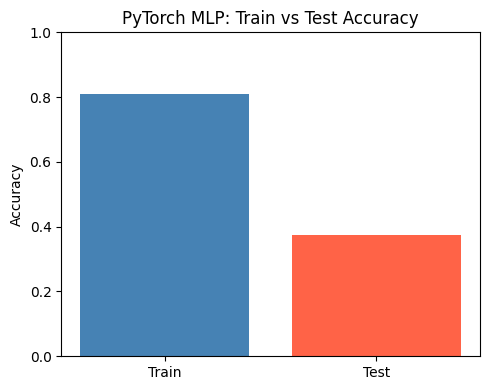

In [24]:
# PART D: 


model.eval()

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

with torch.no_grad():
    test_output = model(X_test_tensor)
    test_preds  = test_output.argmax(dim=1).numpy()
    test_acc    = accuracy_score(y_test_final, test_preds)

with torch.no_grad():
    train_preds_pt = model(X_train_tensor).argmax(dim=1)
    train_acc_pt   = (train_preds_pt == y_train_tensor).float().mean().item()

relu_test_probs, _, _ = relu_mlp.forward(X_test_scaled)
relu_test_acc = relu_mlp.accuracy(relu_test_probs, y_test_final)

sig_test_probs, _, _ = sig_mlp.forward(X_test_scaled)
sig_test_acc = sig_mlp.accuracy(sig_test_probs, y_test_final)

print("=" * 55)
print(f"  PyTorch MLP   | Train: {train_acc_pt:.4f} | Test: {test_acc:.4f}")
print(f"  NumPy ReLU    | Train: {r_train_accs[-1]:.4f} | Val: {r_val_accs[-1]:.4f} | Test: {relu_test_acc:.4f}")
print(f"  NumPy Sigmoid | Train: {s_train_accs[-1]:.4f} | Val: {s_val_accs[-1]:.4f} | Test: {sig_test_acc:.4f}")
print("=" * 55)

print("\n=== Classification Report (PyTorch, Test Set) ===")
print(classification_report(y_test_final, test_preds,
      target_names=['Budget', 'Moderate', 'Premium', 'Luxury']))

plt.figure(figsize=(5, 4))
plt.bar(['Train', 'Test'], [train_acc_pt, test_acc], color=['steelblue', 'tomato'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('PyTorch MLP: Train vs Test Accuracy')
plt.tight_layout()
plt.show()
